In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

#PDFs in BDT and sindec?
import os

# set env flags to catch BLAS used for scipy/numpy 
# to only use 1 cpu, n_cpus will be totally controlled by csky
if False:
    os.environ['MKL_NUM_THREADS'] = "1"
    os.environ['NUMEXPR_NUM_THREADS'] = "1"
    os.environ['OMP_NUM_THREADS'] = "1"
    os.environ['OPENBLAS_NUM_THREADS'] = "1"
    os.environ['VECLIB_MAXIMUM_THREADS'] = "1"

import matplotlib as mpl
mpl.rcParams['figure.facecolor'] = 'w'
mpl.rcParams['savefig.facecolor'] = 'w'
import matplotlib.pyplot as plt
from matplotlib import colors, cm
import csky as cy
from csky import cext
import numpy as np
import astropy
#from icecube import astro
import histlite as hl
import healpy
import healpy as hp
import socket
import pickle
import copy
healpy.disable_warnings()
plt.rc('figure', facecolor = 'w')
plt.rc('figure', dpi=100)

## Define Settings

In [ ]:
selection_version = 'version-001-p00'

host_name = socket.gethostname()

if 'cobalt' in host_name:
    print('Working on Cobalts')
    data_prefix = '/data/user/ssclafani/data/cscd/final'
    ana_dir = '/data/user/ssclafani/data/analyses/'
    plot_dir = '/data/user/mhuennefeld/data/analyses/DNNCascadeCodeReview/unblinding_checks/plots/unblinding/model_confusion_stacking'
    
else:
    raise ValueError('Unknown host:', host_name)

In [ ]:
for dir_path in [plot_dir]:
    if not os.path.exists(dir_path):
        print('Creating directory:', dir_path)
        os.makedirs(dir_path)

## Load Data

In [ ]:
repo = cy.selections.Repository()
specs = cy.selections.DNNCascadeDataSpecs.DNNC_10yr

In [ ]:
%%time

ana = cy.get_analysis(
    repo, selection_version, specs, 
    #gammas=np.r_[0.1:6.01:0.125],
)

In [ ]:
a = ana.anas[0]
a.sig

In [ ]:
a.bg_data

## Helpers

In [ ]:
from cycler import cycle
from copy import deepcopy

soft_colors = cy.plotting.soft_colors
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']


def get_bias_allt(tr, ntrials=200, n_sigs=np.r_[:101:10], quiet=False):
    trials = [
        (None if quiet else print(f'\r{n_sig:4d} ...', end='', flush=True))
        or
        tr.get_many_fits(ntrials, n_sig=n_sig, logging=False, seed=n_sig)
        for n_sig in n_sigs]
    if not quiet:
        print()
    for (n_sig, t) in zip(n_sigs, trials):
        t['ntrue'] = np.repeat(n_sig, len(t))
    allt = cy.utils.Arrays.concatenate(trials)
    return allt

def get_color_cycler():
    return cycle(colors)

def plot_ns_bias(ax, tr, allt, label=''):

    n_sigs = np.unique(allt.ntrue)
    dns = np.mean(np.diff(n_sigs))
    ns_bins = np.r_[n_sigs - 0.5*dns, n_sigs[-1] + 0.5*dns]
    expect_kw = dict(color='C0', ls='--', lw=1, zorder=-10)

    h = hl.hist((allt.ntrue, allt.ns), bins=(ns_bins, 100))
    hl.plot1d(ax, h.contain_project(1),errorbands=True, 
              drawstyle='default', label=label)
    lim = ns_bins[[0, -1]]
    ax.set_xlim(ax.set_ylim(lim))
    ax.plot(lim, lim, **expect_kw)
    ax.set_aspect('equal')

    ax.set_xlabel(r'$n_{inj}$')
    ax.set_ylabel(r'$n_s$')
    ax.grid()

def plot_gamma_bias(ax, tr, allt, label=''):

    n_sigs = np.unique(allt.ntrue)
    dns = np.mean(np.diff(n_sigs))
    ns_bins = np.r_[n_sigs - 0.5*dns, n_sigs[-1] + 0.5*dns]
    expect_kw = dict(color='C0', ls='--', lw=1, zorder=-10)
    expect_gamma = tr.sig_injs[0].flux[0].gamma

    h = hl.hist((allt.ntrue, allt.gamma), bins=(ns_bins, 100))
    hl.plot1d(ax, h.contain_project(1),errorbands=True, 
              drawstyle='default', label=label)
    lim = ns_bins[[0, -1]]
    ax.set_xlim(lim)
    ax.set_ylim(1, 4)
    ax.axhline(expect_gamma, **expect_kw)

    ax.set_xlabel(r'$n_{inj}$')
    ax.set_ylabel(r'$\gamma$')
    ax.grid()

def plot_bkg_trials(
            bg, fig=None, ax=None, 
            label='{} bg trials', 
            label_fit=r'$\chi^2[{:.2f}\mathrm{{dof}},\ \eta={:.3f}]$', 
            color=colors[0],
            density=False,
            bins=50,
        ):
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 4))
    
    if density:
        h = bg.get_hist(bins=bins).normalize()
    else:
        h = bg.get_hist(bins=bins)
    if label is not None:
        label = label.format(bg.n_total)
    hl.plot1d(ax, h, crosses=True, color=color, label=label)

    # compare with the chi2 fit:
    if hasattr(bg, 'pdf'):
        x = h.centers[0]
        norm = h.integrate().values
        if label_fit is not None:
            label_fit = label_fit.format(bg.ndof, bg.eta)
        if density:
            ax.semilogy(x, bg.pdf(x), lw=1, ls='--', label=label_fit, color=color)
        else:
            ax.semilogy(x, norm * bg.pdf(x), lw=1, ls='--', label=label_fit, color=color)

    ax.set_xlabel(r'TS')
    if density:
        ax.set_ylabel(r'Density')
    else:
        ax.set_ylabel(r'number of trials')
    ax.legend()
        
    return fig, ax

## Setup Analysis

In [ ]:
import sys
sys.path.insert(0, '../..')

import config as cg

cg.base_dir = '/data/user/mhuennefeld/data/analyses/unblinding_v1.0.0/'

In [ ]:
def get_gp_tr(template_str, cutoff=np.inf, gamma=None, cpus=20):
    cutoff_GeV = cutoff * 1e3
    gp_conf = cg.get_gp_conf(
        template_str=template_str, gamma=gamma, cutoff_GeV=cutoff_GeV, base_dir=cg.base_dir)
    tr = cy.get_trial_runner(gp_conf, ana=ana, mp_cpus=cpus)
    return tr

def get_catalog_tr(catalog, cutoff=np.inf, gamma=2.0, cpus=20):
    catalog_file = os.path.join(
        cg.catalog_dir, '{}_ESTES_12.pickle'.format(catalog))
    cat = np.load(catalog_file, allow_pickle=True)
    src = cy.utils.Sources(dec=cat['dec_deg'], ra=cat['ra_deg'], deg=True)
    cutoff_GeV = cutoff * 1e3

    conf = cg.get_ps_conf(src=src, gamma=gamma, cutoff_GeV=cutoff_GeV)
    tr = cy.get_trial_runner(ana=ana, conf=conf, mp_cpus=cpus)
    return tr


#### Get TrialRunners

In [ ]:
inj_tr_dict = {
    'pi0': get_gp_tr('pi0'),
    'kra5': get_gp_tr('kra5'),
    'kra50': get_gp_tr('kra50'),
}

tr_dict = {
    'snr': get_catalog_tr('snr'),
    'pwn': get_catalog_tr('pwn'),
    'unid': get_catalog_tr('unid'),
}

#### Get bkg fits for each template

In [ ]:
bkg_file_dict = {
    'pi0': '{}/gp/trials/{}/{}/trials.dict'.format(cg.base_dir, 'DNNC', 'pi0'),
    'kra5': '{}/gp/trials/{}/{}/trials.dict'.format(cg.base_dir, 'DNNC', 'kra5'),
    'kra50': '{}/gp/trials/{}/{}/trials.dict'.format(cg.base_dir, 'DNNC', 'kra50'),
    'snr': '{}/stacking/{}_bg.dict'.format(cg.base_dir, 'snr'),
    'pwn': '{}/stacking/{}_bg.dict'.format(cg.base_dir, 'pwn'),
    'unid': '{}/stacking/{}_bg.dict'.format(cg.base_dir, 'unid'),
}
n_bkg_trials = 20000
seed = 1337

bkg_dict = {}
for key, tr in tr_dict.items():
    if key in bkg_file_dict:
        print('Loading background trials for template {}'.format(key))
        sig = np.load(bkg_file_dict[key], allow_pickle=True)
        if key in ['pi0', 'kra5', 'kra50']:
            bkg_dict[key] = sig['poisson']['nsig'][0.0]['ts']
        else:
            bkg_dict[key] = sig
    
    else:
        print('Running background trials for template {}'.format(key))
        bkg_dict[key] = tr.get_many_fits(
            n_trials=n_bkg_trials, seed=seed, mp_cpus=20)
        

#### Get Results for each template

In [14]:
res_dict = {}
for key in tr_dict.keys():
    if key in ['pi0', 'kra5', 'kra50']:
        f_path = os.path.join(
            cg.base_dir, 
            'gp/results/{}/{}_unblinded.npy'.format(key, key), 
        )
        res_dict[key] = np.load(f_path)
    elif key in ['snr', 'pwn', 'unid']:
        f_path = os.path.join(
            cg.base_dir, 
            'stacking/results/{}/{}_unblinded.npy'.format(key, key), 
        )
        res_dict[key] = np.load(f_path)

#### Plot ts distribution

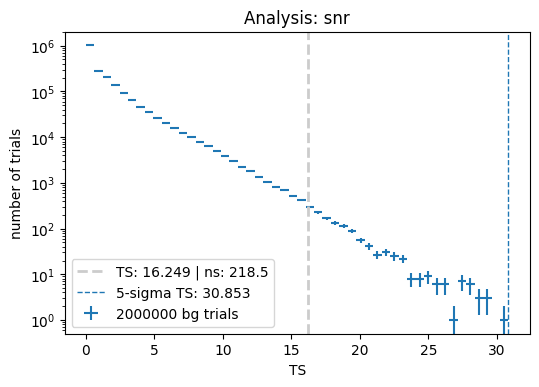

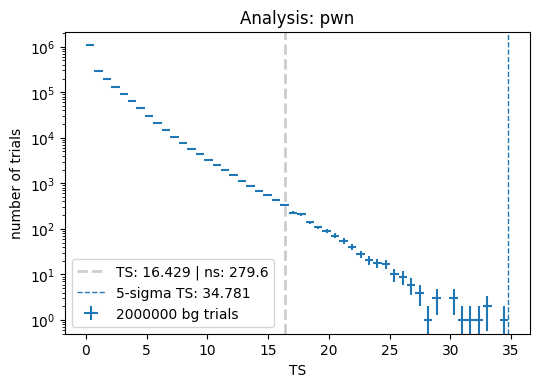

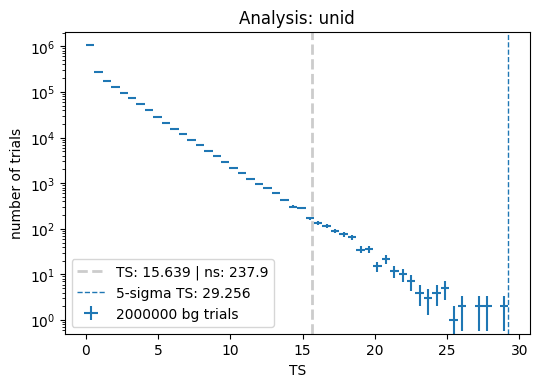

In [18]:
for key, bg in bkg_dict.items():
    bg_tsd = cy.dists.TSD(bg)
    fig, ax = plot_bkg_trials(bg_tsd)
    ts = res_dict[key][0]
    ns = res_dict[key][1]
    ax.axvline(
        ts, color='0.8', ls='--', lw=2,
        label='TS: {:3.3f} | ns: {:3.1f}'.format(ts, ns), 
    )
    ts_5sig = bg_tsd.isf_nsigma(5)
    ax.axvline(
        ts_5sig, ls='--', lw=1,
        label='5-sigma TS: {:3.3f}'.format(ts_5sig), 
    )
    ax.set_title('Analysis: {}'.format(key))
    ax.set_yscale('log')
    ax.legend()
    fig.savefig('{}/ts_dist_{}.png'.format(plot_dir, key))

#### Compute Significance

In [ ]:
p_val_dict = {}
sigma_dict = {}
max_n = 100000
for key, bg in bkg_dict.items():
    print('key:', key)
    bg_tsd = cy.dists.TSD(bg[:max_n])
    p_val_dict[key] = bg_tsd.sf(bg[:max_n])
    sigma_dict[key] = bg_tsd.sf_nsigma(bg[:max_n])


key: snr


#### Plot Trial Correlation

In [ ]:
mask = np.zeros_like(bkg_dict['snr'][:max_n])
sigma_threshold = 0.5

for key, tr in sigma_dict.items():

    mask = np.logical_or(mask, sigma_dict[key] > sigma_threshold)
    

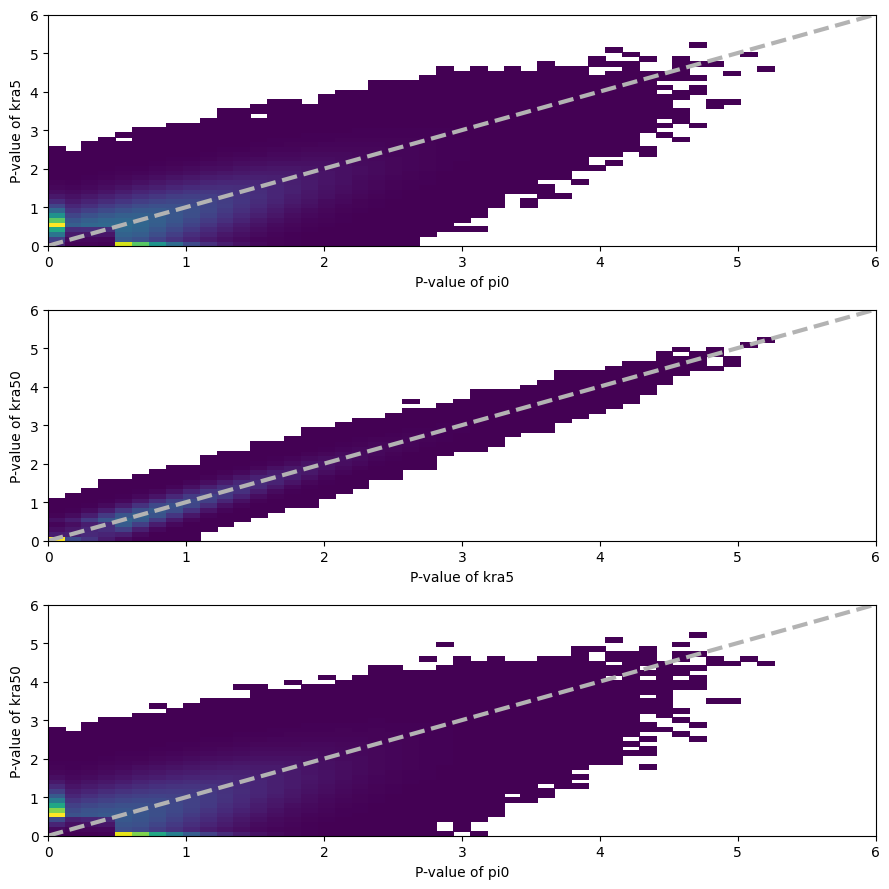

In [21]:
import matplotlib as mpl

def plot_corr_ax(ax, key1, key2, mask=None, norm=None):
    
    if mask is None:
        mask = np.ones_like(sigma_dict[key1], dtype=bool)
        
    ax.hist2d(
        sigma_dict[key1][mask], sigma_dict[key2][mask],
        bins=bins, norm=norm, cmin=1,
    )
    ax.plot(
        (bins[0][0], bins[0][-1]), (bins[0][0], bins[0][-1]), 
        ls='--', color='0.7', lw=3,
    )
    ax.set_xlabel('P-value of {}'.format(key1))
    ax.set_ylabel('P-value of {}'.format(key2))

fig, axes = plt.subplots(3, 1, figsize=(9, 9))

bins = (np.linspace(0, 6), np.linspace(0, 6))

plot_corr_ax(axes[0], 'snr', 'pwn', mask=mask)
plot_corr_ax(axes[1], 'snr', 'unid', mask=mask)
plot_corr_ax(axes[2], 'unid', 'pwn', mask=mask)
fig.tight_layout()


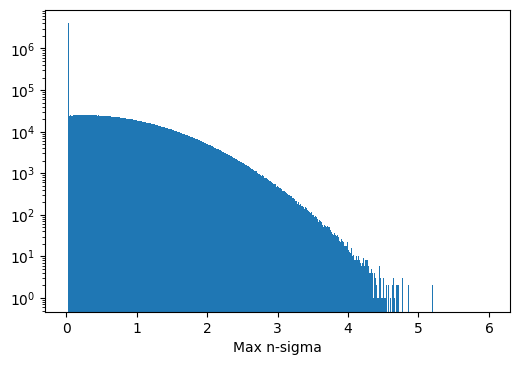

In [22]:
max_nsigma = np.max(
    np.array([sigma_dict[k] for k in sigma_dict.keys()]),
    axis=0,
)

fig, ax = plt.subplots()
ax.hist(max_nsigma, bins=np.linspace(0, 6, 1000))
ax.set_xlabel('Max n-sigma')
ax.set_yscale('log')

bg_max = cy.dists.TSD(max_nsigma)


In [30]:
from scipy import stats


nsigma_chosen = 4.68
pval_chosen = stats.norm.sf(nsigma_chosen)
nsigma_corrected = bg_max.sf_nsigma(nsigma_chosen)

pval_corrected = bg_max.sf(nsigma_chosen)
print(nsigma_corrected, pval_corrected/pval_chosen)
print(stats.norm.isf(pval_chosen * 3))


4.526389321393594 2.0915038739429384
4.449519851988547


#### Define number of ns to inject

In [ ]:
ns_dict = {
    'pi0': 748.11,
    'kra5': 273.24,
    'kra50': 208.95,
}

#### Get trials for each template

In [ ]:
from tqdm.notebook import tqdm_notebook as tqdm

n_trials = 100
seed = 42
trials_dict = {}

for key, tr in inj_tr_dict.items():
    
    n_sig = ns_dict[key]
    trials = []
    
    print('Injecting {} signal events for template {}'.format(n_sig, key))
    for i in tqdm(range(n_trials), total=n_trials):
        trials.append(tr.get_one_trial(n_sig=n_sig, poisson=True, seed=seed + i))
    
    trials_dict[key] = trials
    

#### Get fits for each template combination

In [ ]:
ts_dict = {}
for key_inj, tr_inj in inj_tr_dict.items():
    
    for key, tr in tr_dict.items():
        print('Computing TS values for injection {} and testing with {}'.format(key_inj, key))

        ts_values = []
        n_values = len(trials_dict[key_inj])
        for trial in tqdm(trials_dict[key_inj], total=n_values):
            ts_values.append(tr.get_one_fit_from_trial(trial)) 
        
        ts_values = np.array(ts_values)
        ts_dict[(key_inj, key)] = cy.utils.Arrays({
          'ts': ts_values[:, 0],  
          'ns': ts_values[:, 1],  
        })




#### Compute Significance

In [ ]:
p_val_dict = {}
sigma_dict = {}
for key, ts_values in ts_dict.items():
    bg = bkg_dict[key[1]]
    max_bg_ts = np.max(bg.values)
    mask_above = ts_values.ts > max_bg_ts
    ts = np.array(ts_values.ts)
    if np.sum(mask_above) > 0:
        print('Setting {} ts values to max bkg ts value of {}.'.format(
            np.sum(mask_above), max_bg_ts))
        ts[mask_above] = max_bg_ts
    p_val_dict[key] = bg.sf(ts)
    sigma_dict[key] = bg.sf_nsigma(ts)


#### Plot Distributions

In [ ]:
from itertools import cycle

def plot_model_confusion(template_keys, testing_keys=None, bins=np.linspace(0, 6, 20)):
    n_keys = len(template_keys)
    
    if testing_keys is None:
        testing_keys = template_keys
        
    fig, axes = plt.subplots(n_keys, 1, figsize=(9, 3*n_keys), sharex=True)
    
    if n_keys <= 5:
        color_cycle = cycle(soft_colors)
    else:
        color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

    for i, key_inj in enumerate(template_keys):

        ax = axes[i]
        ax.set_title('Injection template: {}'.format(key_inj))

        for j, key in enumerate(testing_keys):
            sigmas = sigma_dict[(key_inj, key)]
            if not np.isfinite(sigmas).all():
                raise ValueError(sigmas)
            color = next(color_cycle)
            ax.hist(
                sigmas, bins=bins, 
                histtype='step',
                color=color,
                label=r'Testing: {}'.format(key) + ' [$\sigma_{50\%}$ = ' + '{:3.2f}]'.format(np.median(sigmas)),
            )
            ax.axvline(np.median(sigmas), color=color, ls='--')

        ax.plot(np.inf, np.inf, color='0.7', ls='--', label='Median $\sigma$')
        ax.legend(loc='upper left')
        ax.set_ylabel('Frequency')

    axes[-1].set_xlabel('Significance in $\sigma$')

    fig.tight_layout()
    return fig

if False:
    fig = plot_model_confusion(template_keys=['pi0', 'kra5', 'kra50'])
    fig.savefig('{}/model_confusion_nsigma_{:3.2f}.png'.format(plot_dir, nsigma))

fig = plot_model_confusion(template_keys=list(tr_dict.keys()))
fig.savefig('{}/model_confusion_nsigma_{:3.2f}_all.png'.format(plot_dir, nsigma))

fig = plot_model_confusion(
    template_keys=['GalacticCenter', 'GalacticPlane', 'pi0_gamma2', 'pi0_gamma3_10TeV'], 
    testing_keys=['pi0', 'kra5', 'kra50'],
)
fig.savefig('{}/model_confusion_nsigma_{:3.2f}_sys.png'.format(plot_dir, nsigma))

